In [32]:
import tensorflow as tf
from tensorboard.backend.event_processing import event_accumulator
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import numpy as np

import os
os.environ["OMP_NUM_THREADS"] = "8" 
os.environ["OPENBLAS_NUM_THREADS"] = "8" 
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8" 
os.environ["NUMEXPR_NUM_THREADS"] = "8" 

import sys
import pickle as pkl
from functools import partial
import random
import argparse
from datetime import datetime
import traceback

import numpy as np
import tqdm

import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib.animation as animation
from IPython.display import HTML

plt.rcParams['figure.figsize'] = (6, 5)
plt.rcParams['figure.dpi'] = 300

plt.rcParams.update({
    'font.size': 15,
    'text.usetex': False,
})

import jax
import jax.numpy as jnp

os.environ["DDE_BACKEND"] = "jax"
from deepxde_al_patch import deepxde as dde

from deepxde_al_patch.model_loader import construct_model
from deepxde_al_patch.utils import get_pde_residue
from deepxde_al_patch.modified_train_loop import ModifiedTrainLoop
from deepxde_al_patch.plotters import plot_residue_loss, plot_error, plot_prediction, plot_eigvals, plot_eigenbasis, plot_multiple_predictions

from matplotlib.ticker import MaxNLocator


savedir = '/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/plots_meh'


In [2]:

def extract_var(logdir, var, prefix='Loss', kind=None):
    # Load events
    ea = event_accumulator.EventAccumulator(
        logdir,
        size_guidance={
            event_accumulator.SCALARS: 0,
            event_accumulator.HISTOGRAMS: 0
        }
    )
    ea.Reload()
    
    if kind == 'histograms':
        # Extract histogram data
        histo = ea.Histograms(f'{prefix}/{var}')
        return histo
    else:
        # Extract scalar data as before
        scalar_events = ea.Scalars(f'{prefix}/{var}')
        scalar_df = pd.DataFrame([
            {'step': event.step, var: event.value}
            for event in scalar_events
        ])
        return scalar_df


    


In [18]:
# PLOT TRAINING CURVES
scaled = {
    'MultiAdam': '/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_multiadam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106104424-57/tensorboard',
    'PINNacle':'/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106125525-57/tensorboard',
    'NTK-weights':'/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-auto_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106144104-26/tensorboard'
}

unscaled = {
    'MultiAdam': "/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_multiadam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106032635-66/tensorboard",
    'PINNacle':"/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106012102-69/tensorboard",
    'NTK-weights':'/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-auto_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106053602-75/tensorboard'
}

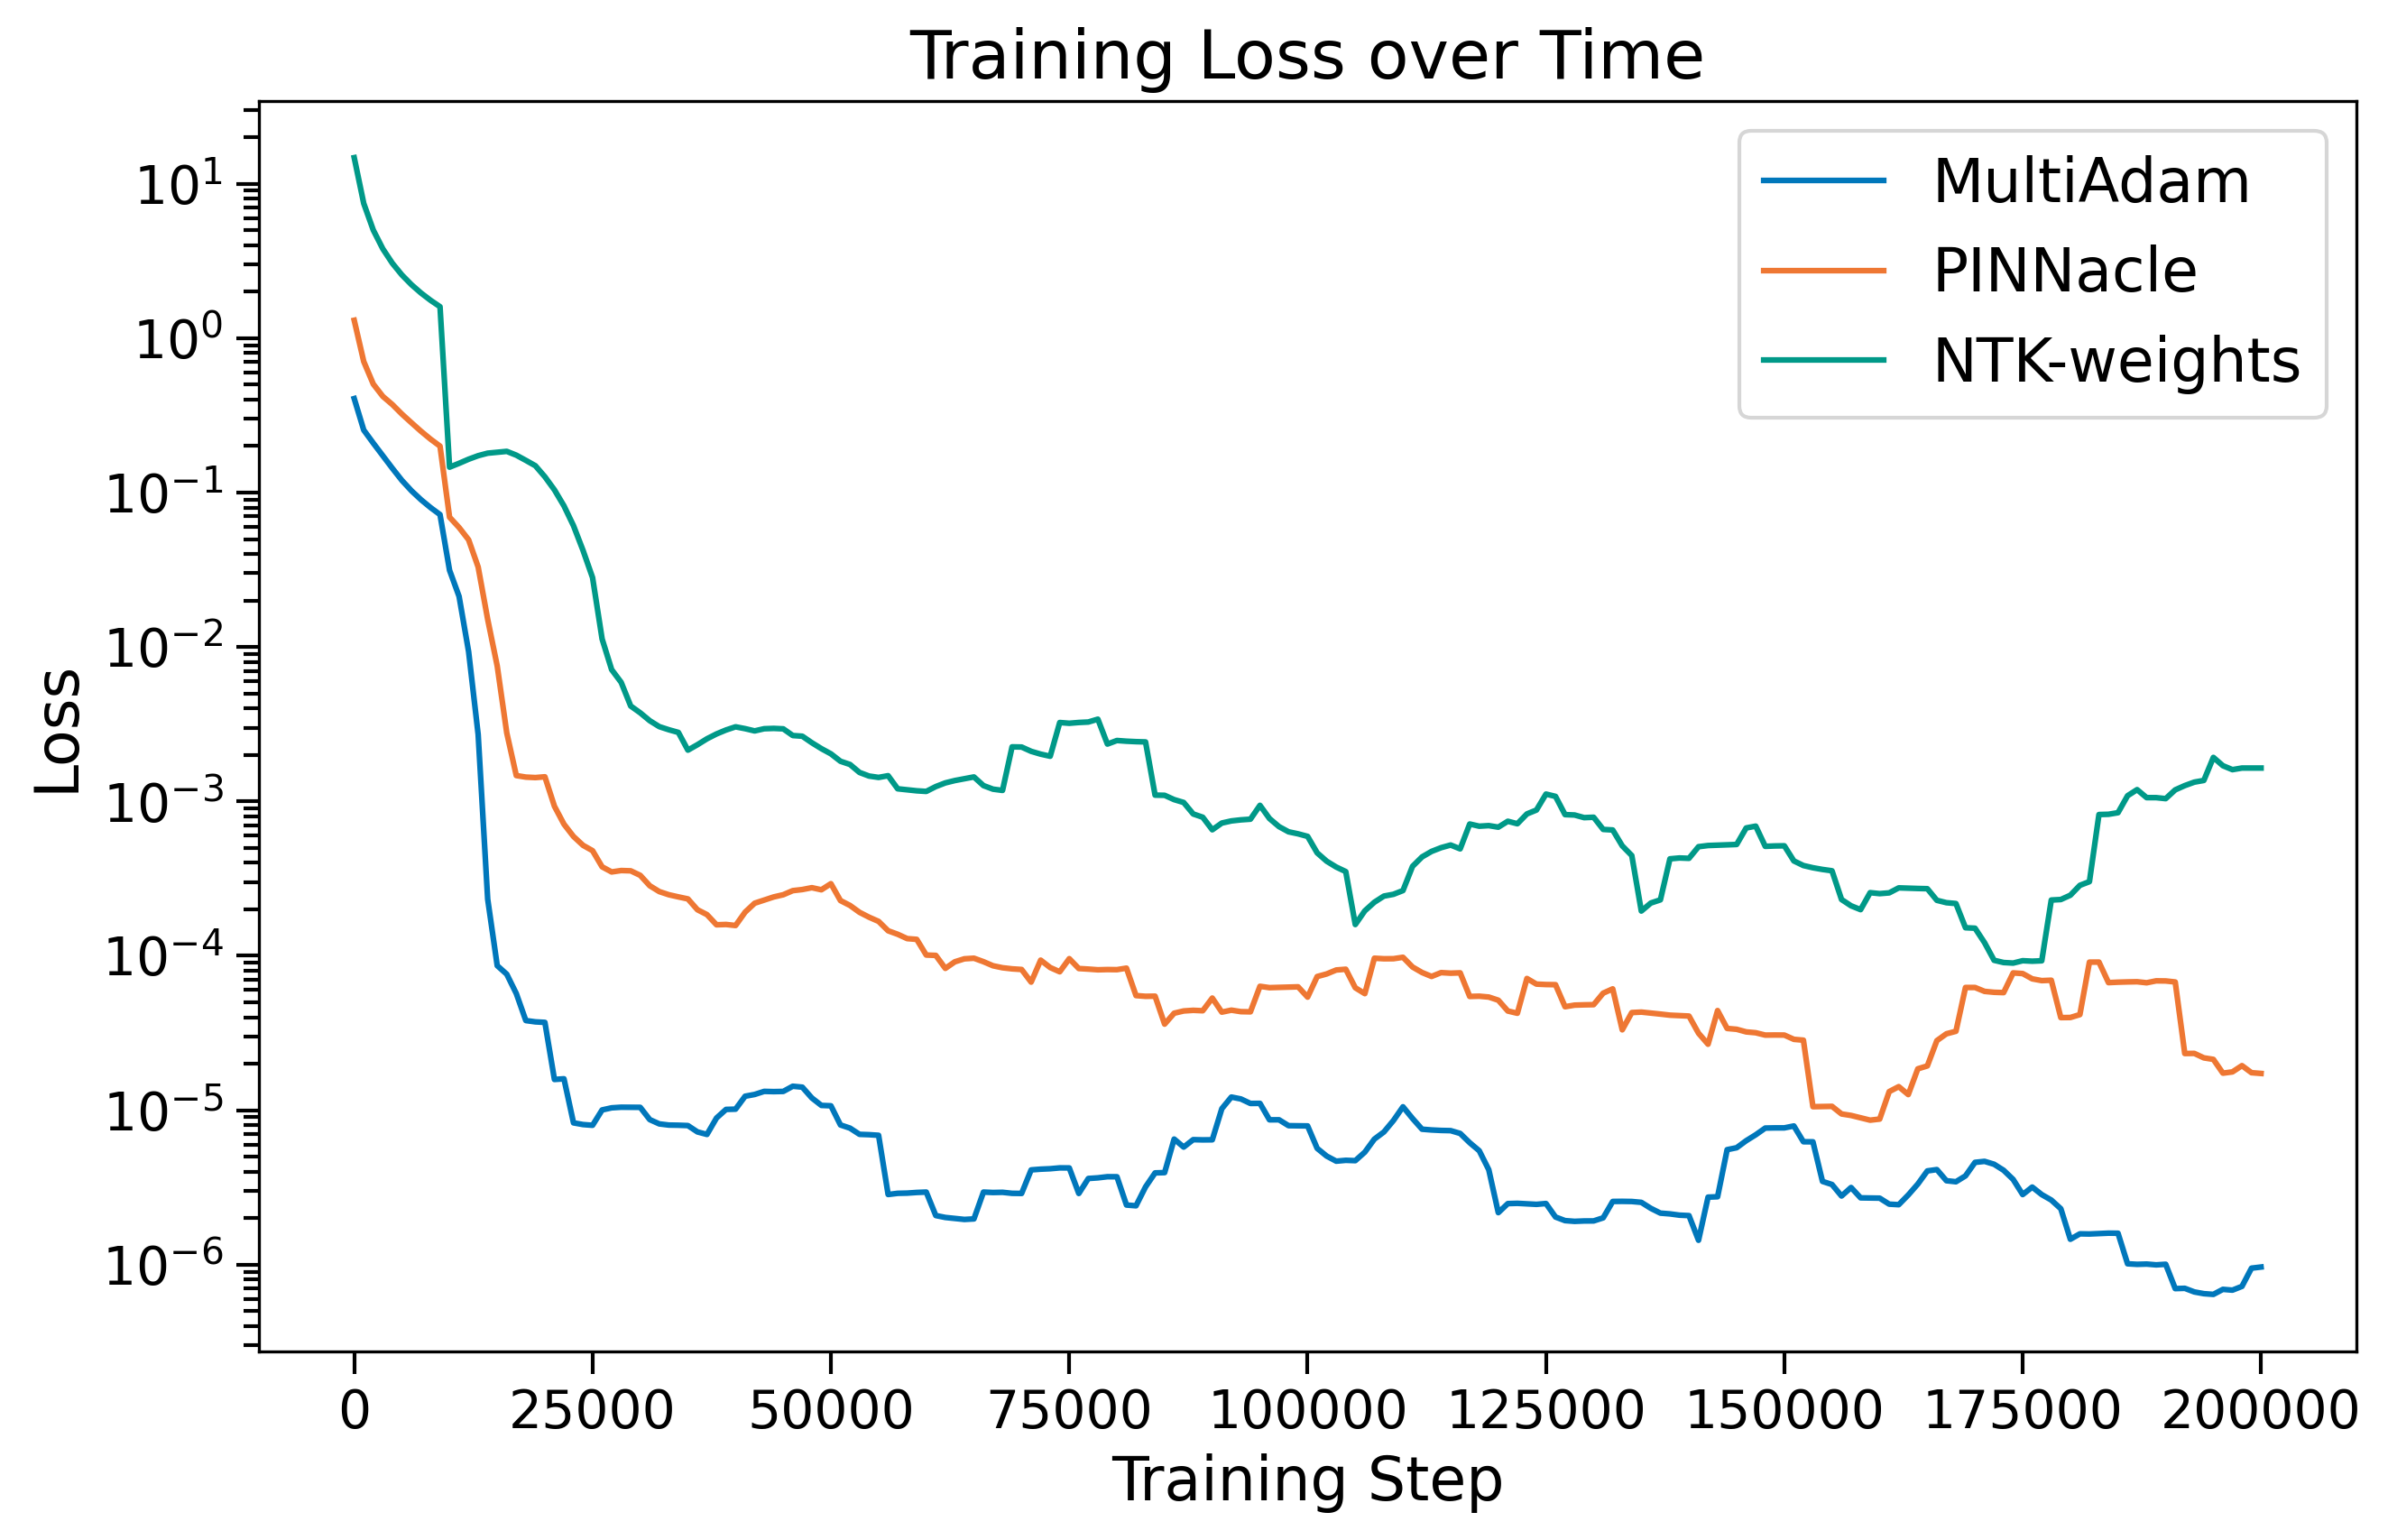

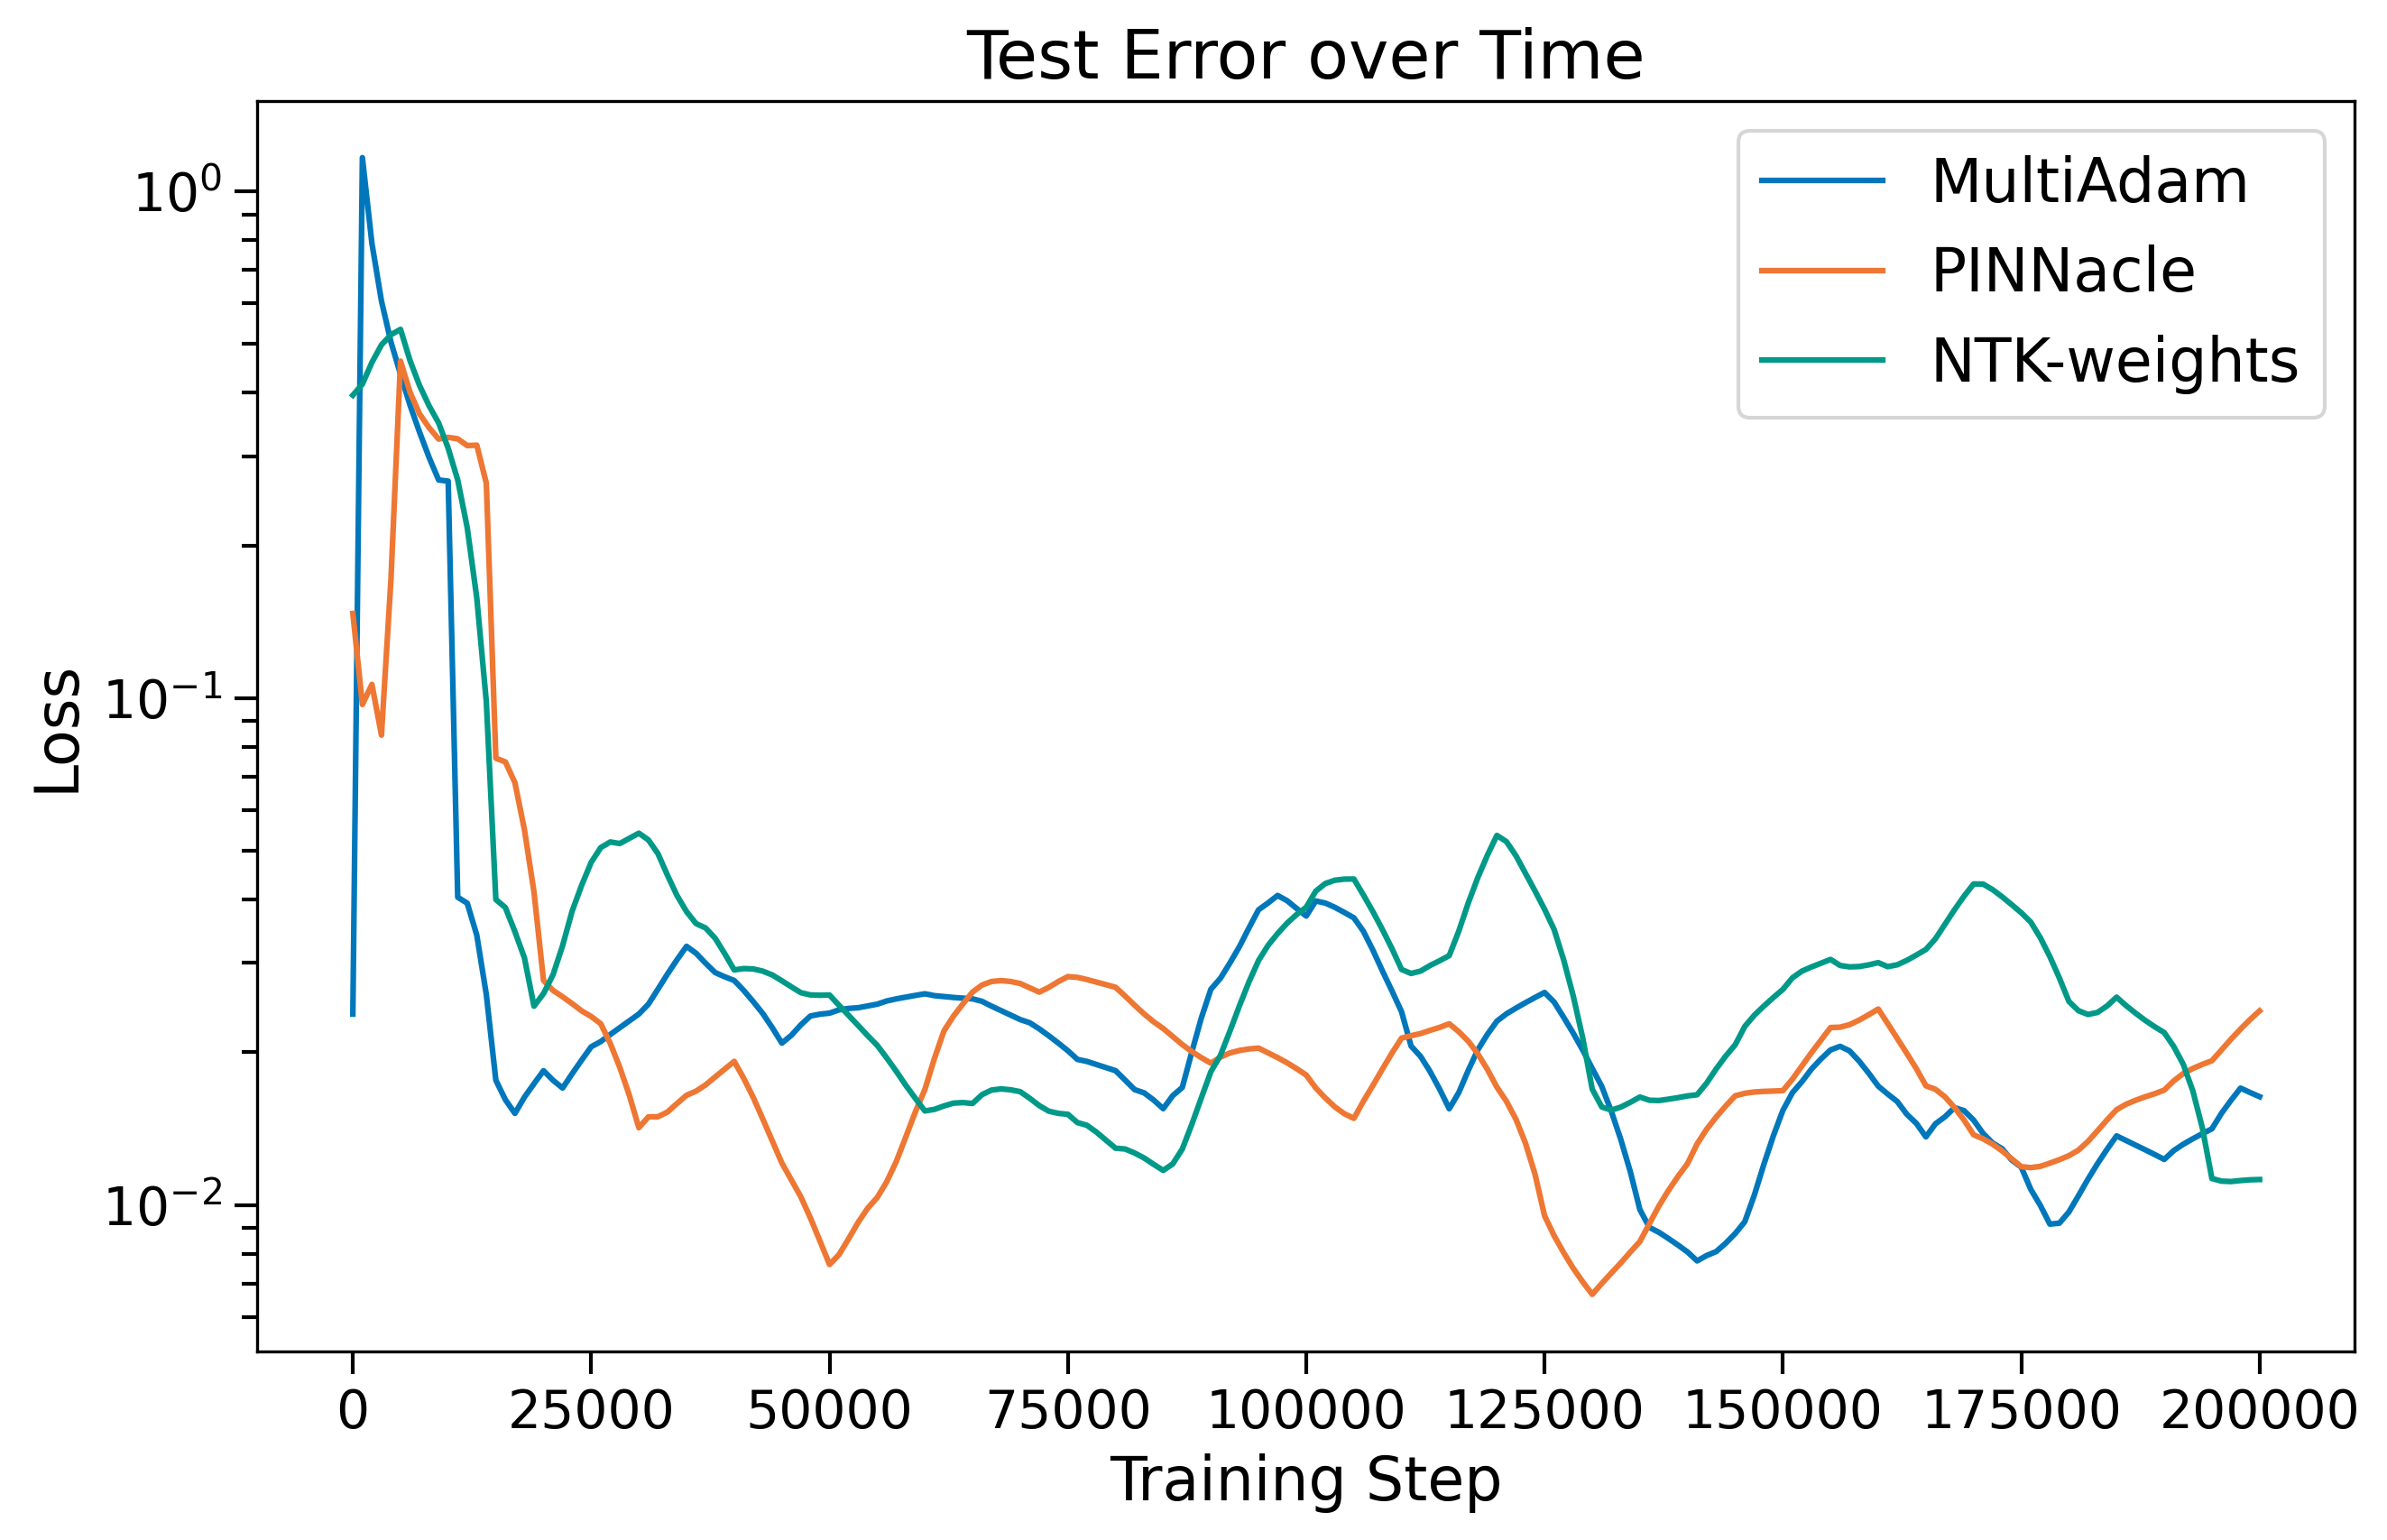

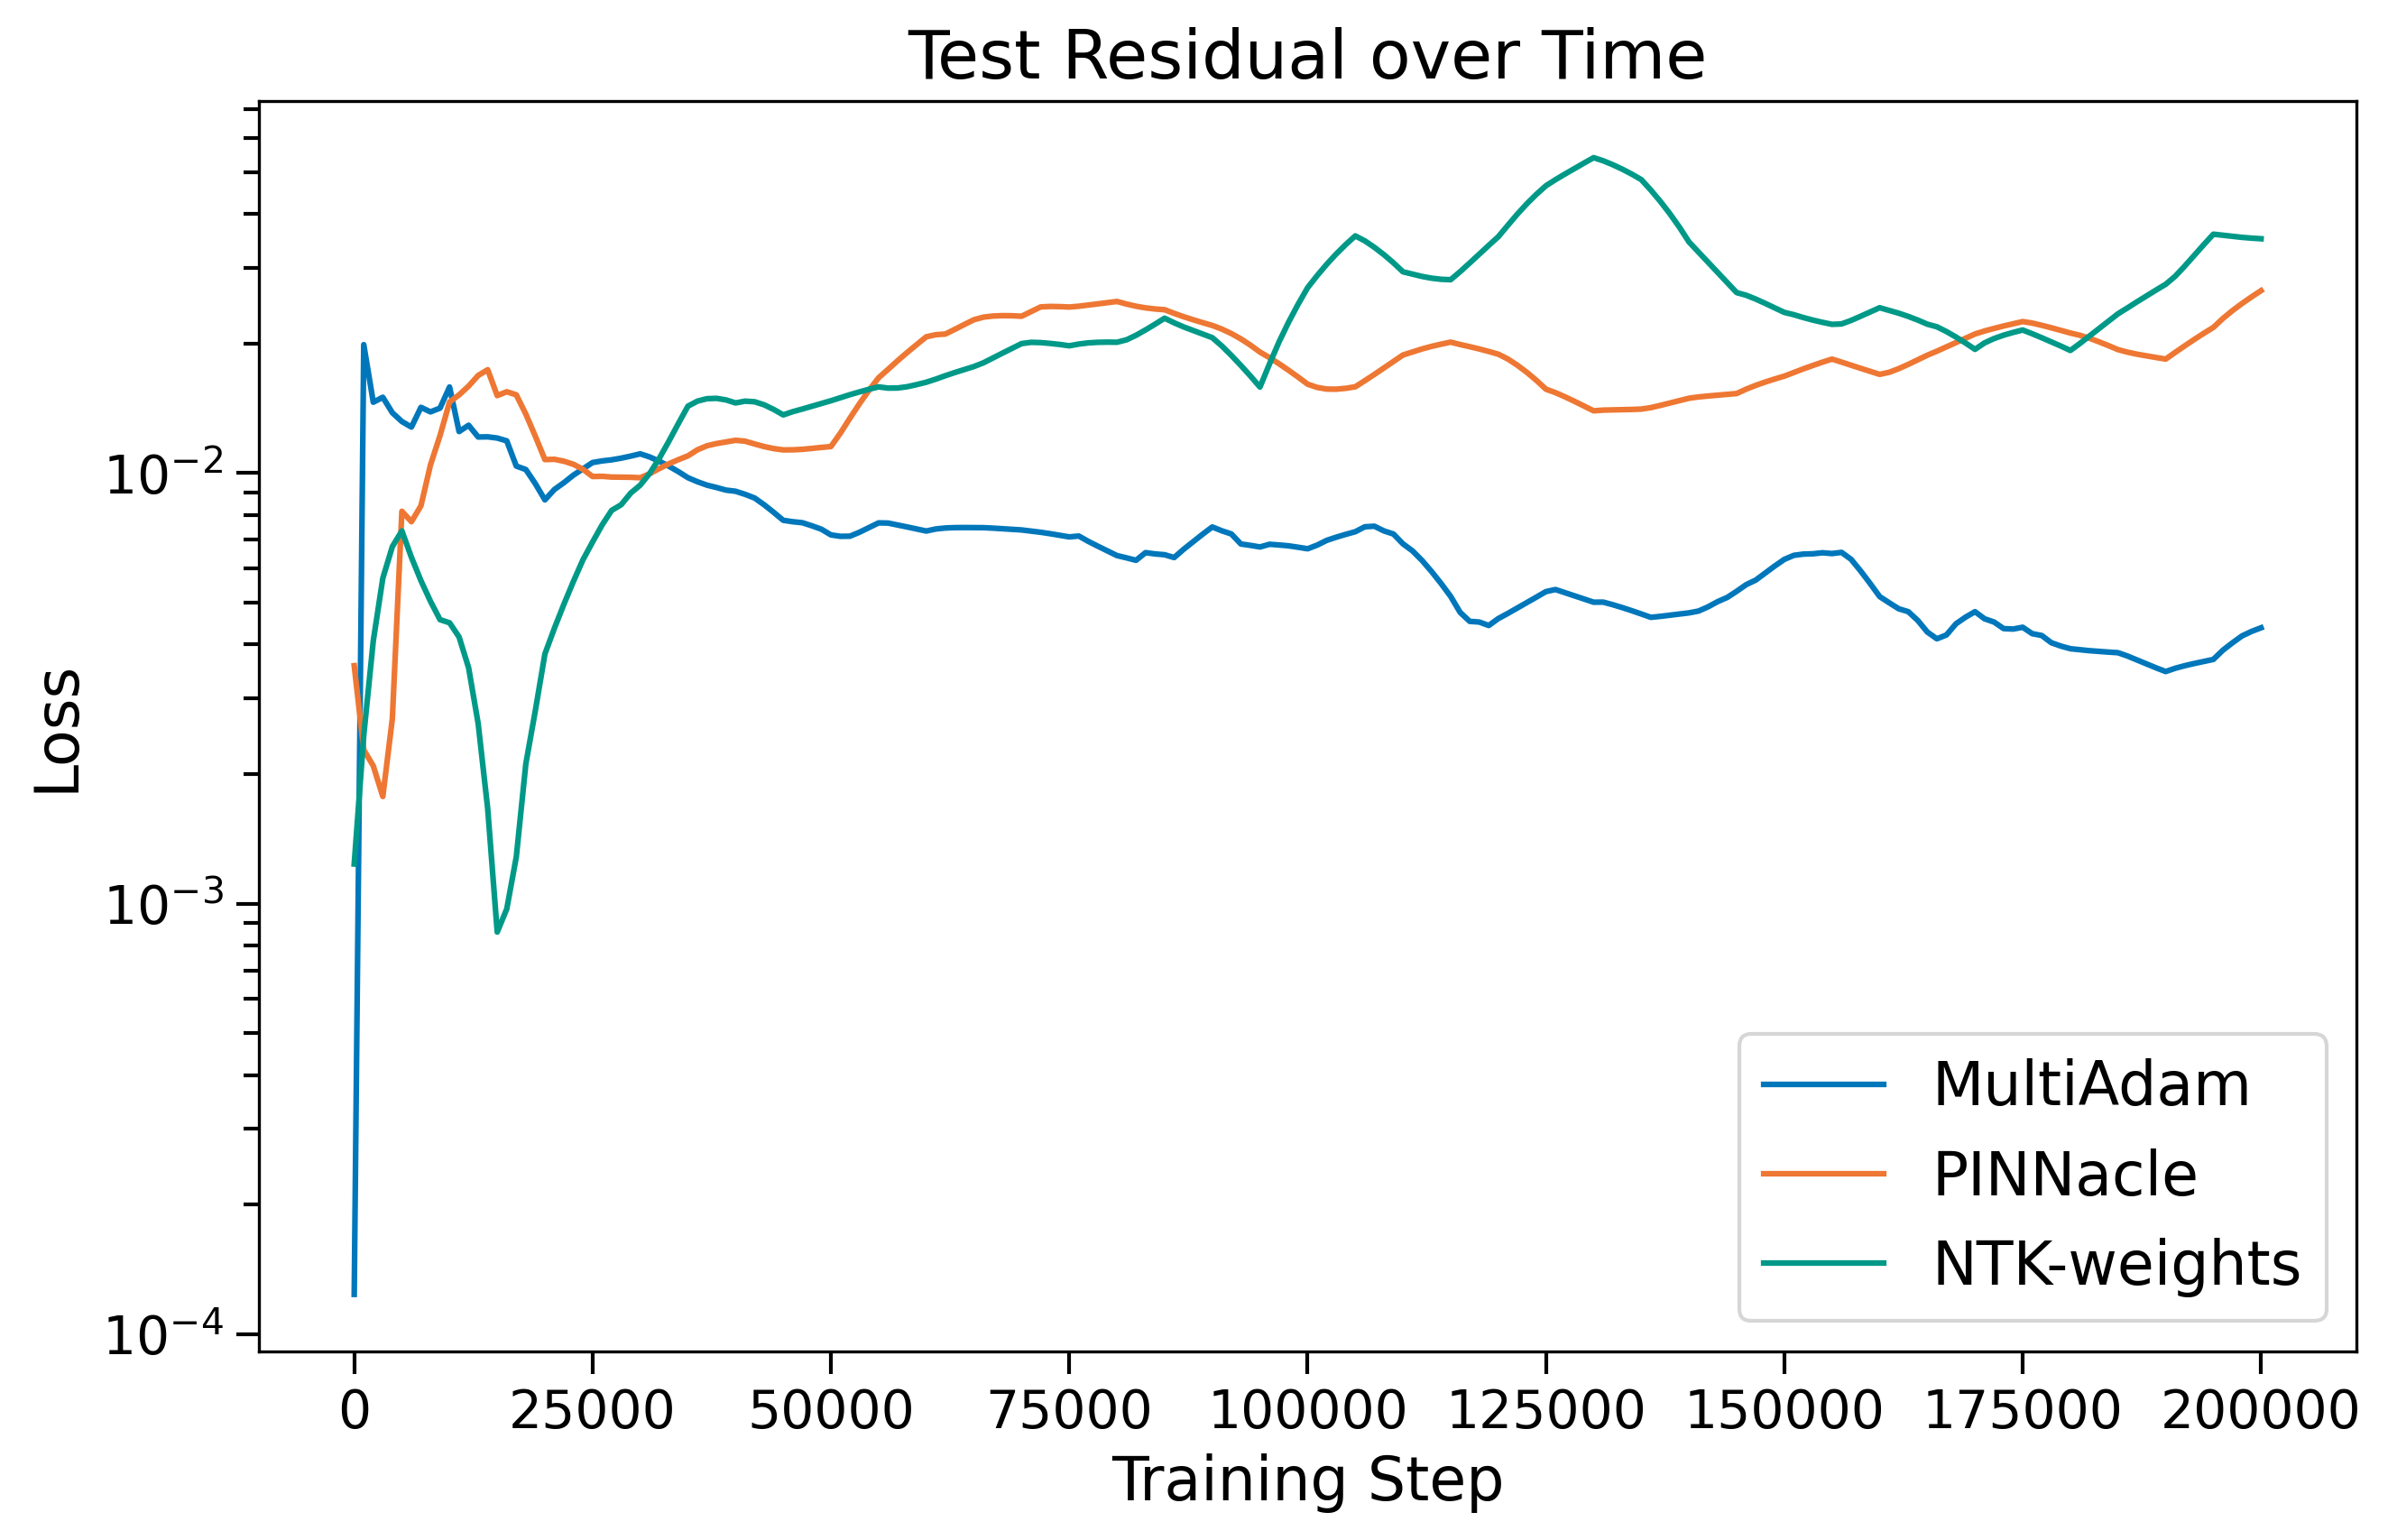

In [21]:
logdirs = scaled

dfs = {}

title_dict = {'train': 'Training Loss', 'test_err': 'Test Error', 'test_res': 'Test Residual'}

for var in ['train', 'test_err', 'test_res']:
    for key in logdirs.keys():
        dfs[key] = extract_var(logdirs[key], var)

    # Create a colorblind-friendly color cycle
    colors = plt.cycler('color', ['#0077BB',  # blue
                                    '#EE7733',    # orange
                                    '#009988',    # teal
                                    '#CC3311',    # red
                                    '#33BBEE',    # cyan
                                    '#EE3377'])   # magenta

    # Set as default color cycle
    plt.rcParams['axes.prop_cycle'] = colors

    # To use as iterator:
    color_cycle = colors()

    # Plot
    plt.figure(figsize=(10,6))
    for key in logdirs.keys():
        color = next(color_cycle)
        df = dfs[key]
        # Apply smoothing with window size 10
        smoothed_values = df[var].rolling(window=10, min_periods=1).mean()
        plt.plot(df['step'], smoothed_values, label=key, color=color['color'])
    plt.yscale('log')
    plt.xlabel('Training Step', fontsize=16)
    plt.ylabel('Loss', fontsize=16)
    plt.title(f'{title_dict[var]} over Time', fontsize=18)
    plt.legend(fontsize=16)

    # Configure tick formatters
    ax = plt.gca()
    # formatter = ScalarFormatter()
    # formatter.set_scientific(True)
    # formatter.set_powerlimits((-3,3))

    # ax.xaxis.set_major_formatter(formatter)
    # ax.yaxis.set_major_formatter(ScalarFormatter())

    # Adjust tick parameters
    ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=1)
    ax.tick_params(axis='both', which='minor', labelsize=12, length=4, width=1)

    plt.savefig(f'{savedir}/{var}_scaled_curve.png')
    plt.show()

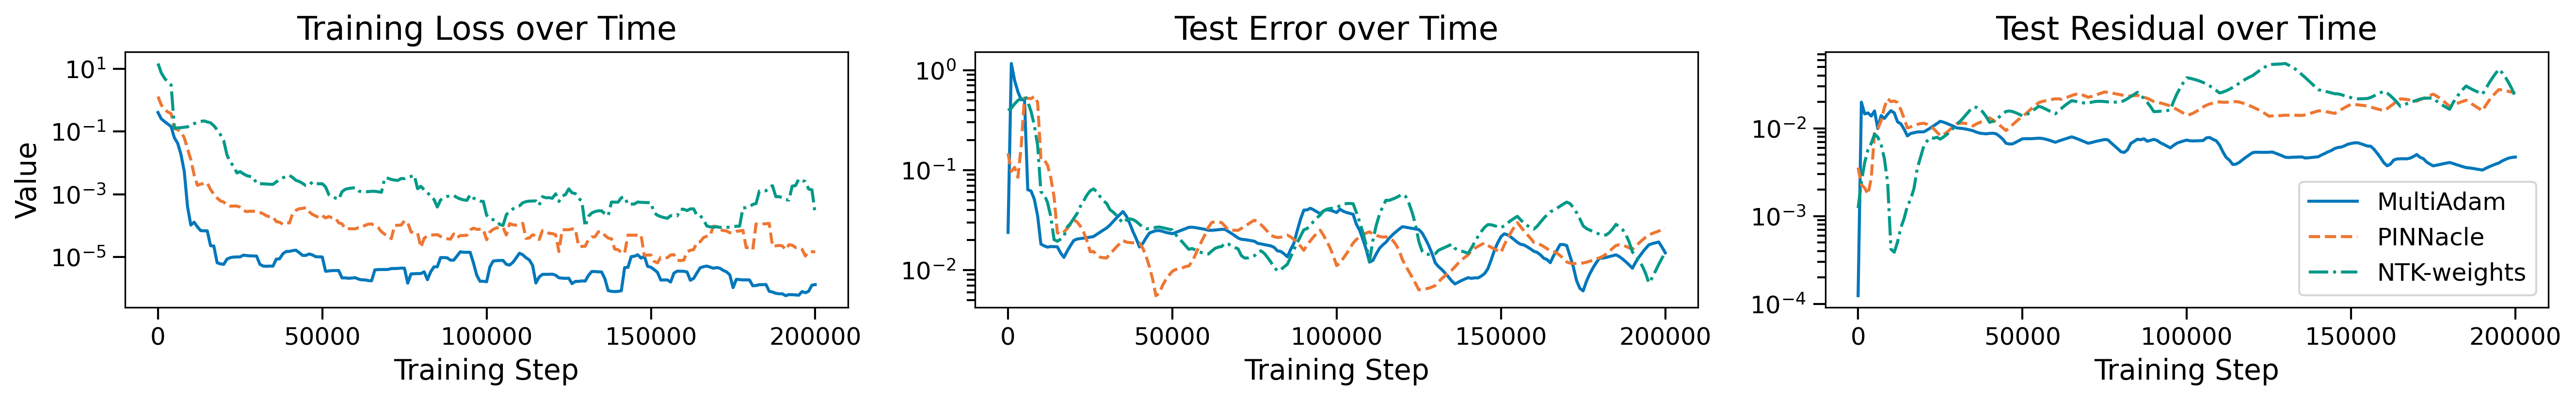

In [36]:
from itertools import cycle

# Create a single figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 3), sharey=False)

dfs = {}

# Iterate over the variables and plot on respective axes
for i, var in enumerate(['train', 'test_err', 'test_res']):
    color_cycle = cycle(['#0077BB', '#EE7733', '#009988', '#CC3311', '#33BBEE', '#EE3377'])
    line_style_cycle = cycle(['-', '--', '-.', ':'])

    
    for key in logdirs.keys():
        dfs[key] = extract_var(logdirs[key], var)
    
    for key in logdirs.keys():
        color = next(color_cycle)
        linestyle = next(line_style_cycle)
        df = dfs[key]
        # Apply smoothing with window size 10
        smoothed_values = df[var].rolling(window=5, min_periods=1).mean()
        axes[i].plot(df['step'], smoothed_values, label=key, color=color, linestyle=linestyle )

    axes[i].set_yscale('log')
    axes[i].set_xlabel('Training Step', fontsize=14)
    axes[0].set_ylabel('Value', fontsize=14)
    axes[i].set_title(f'{title_dict[var]} over Time', fontsize=16)
    axes[i].tick_params(axis='both', which='major', labelsize=12, length=6, width=1)
    axes[i].tick_params(axis='both', which='minor', labelsize=10, length=4, width=1)
    axes[i].xaxis.set_major_locator(MaxNLocator(nbins=5))

# Add legend to the rightmost subplot
handles, labels = axes[-1].get_legend_handles_labels()
axes[-1].legend(handles, labels, loc='lower right', fontsize=12)

# Adjust layout and save the combined figure
plt.tight_layout()
plt.savefig(f'{savedir}/combined_scaled_curve.png')
plt.show()




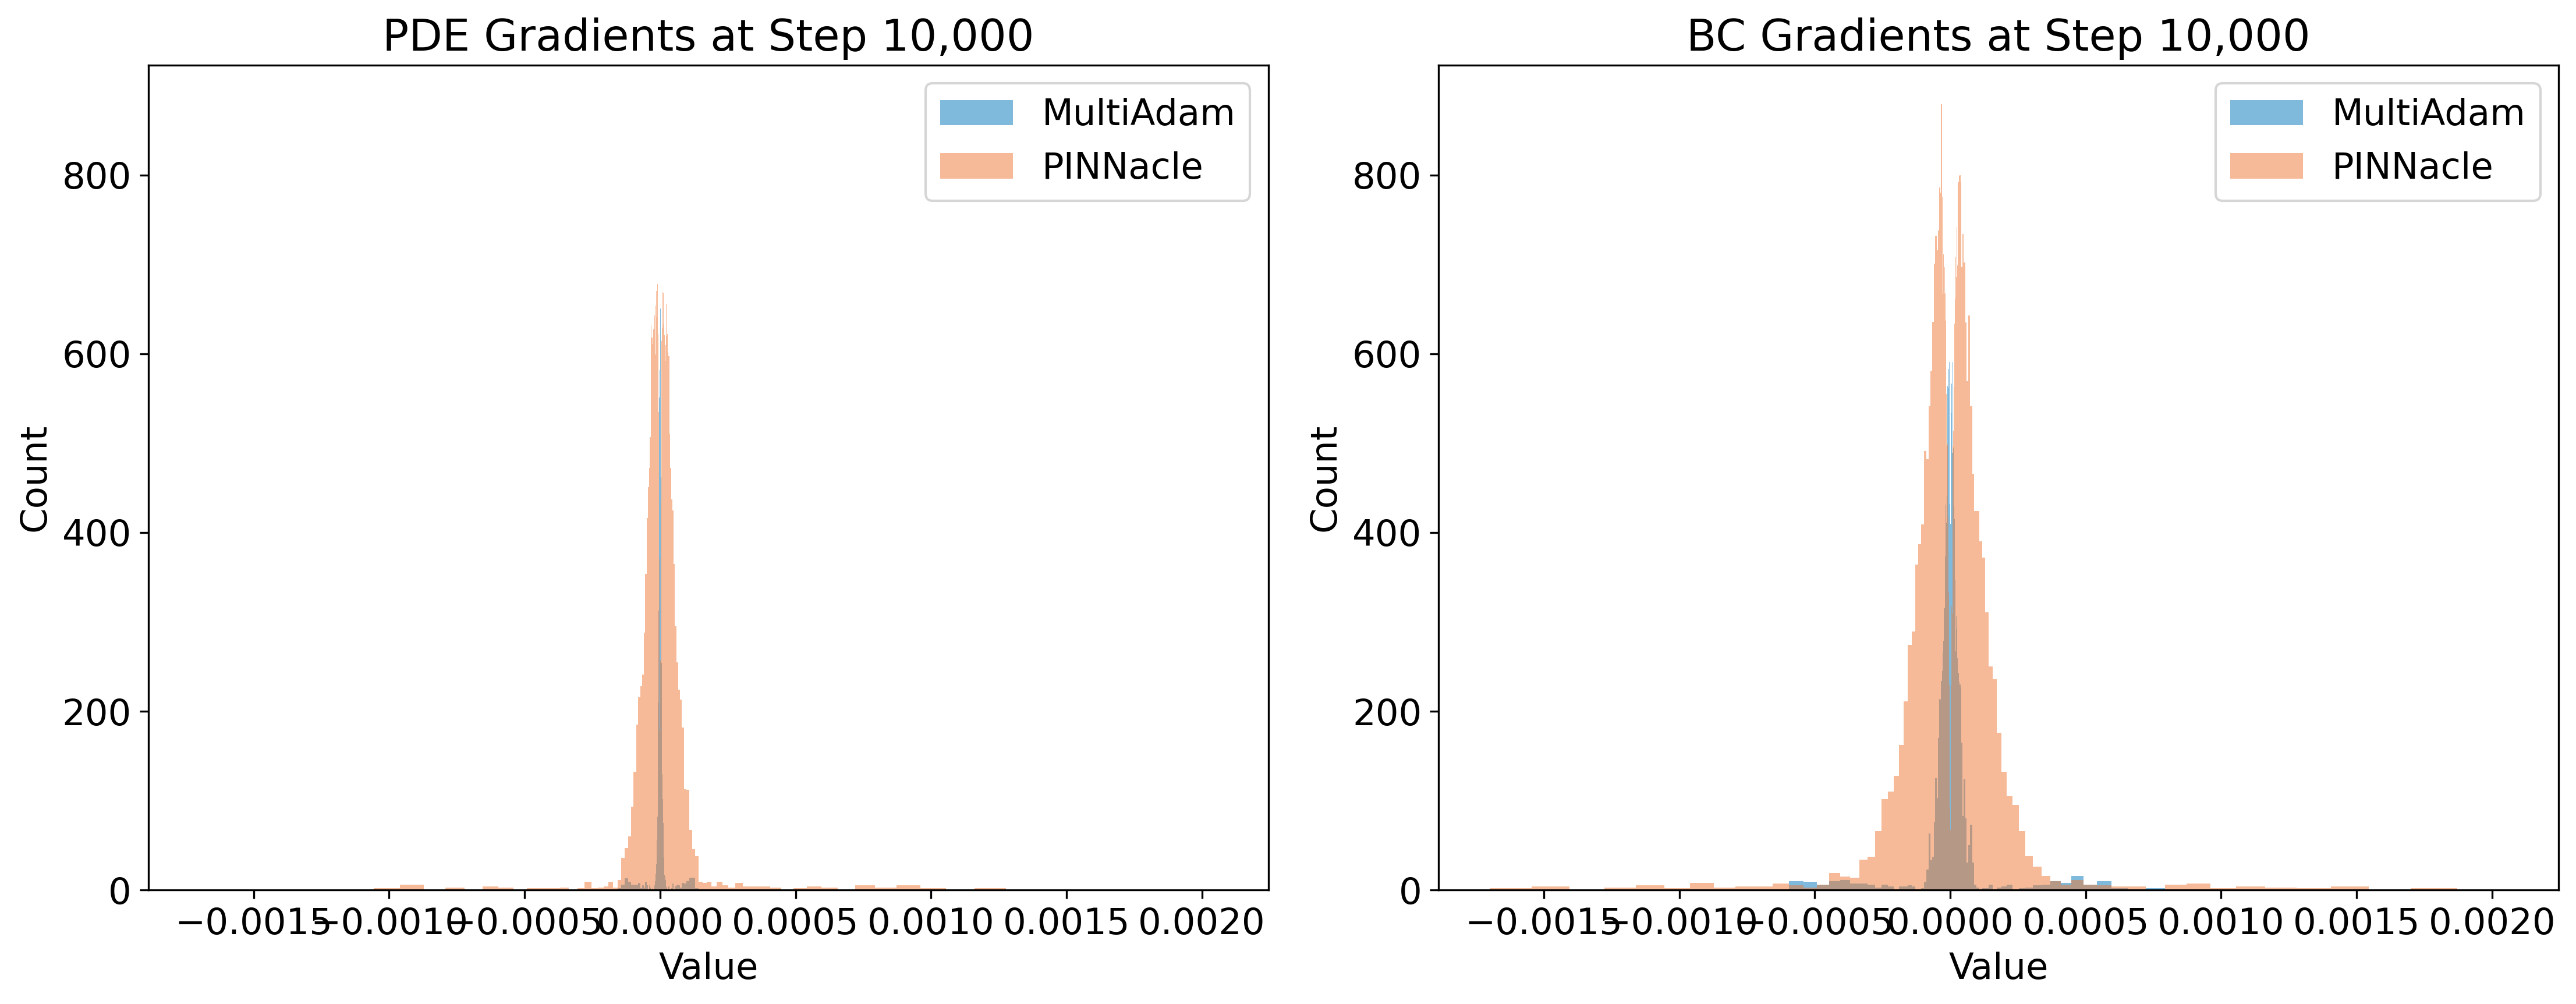

In [4]:
# PLOT TRAINING GRADS
logdirs = {
    'MultiAdam': "/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_multiadam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106104424-57/tensorboard",
    'PINNacle': "/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106125525-57/tensorboard"
    # 'NTK-weights': 
}

# Create a colorblind-friendly color cycle
colors = plt.cycler('color', ['#0077BB',  # blue
                               '#EE7733',  # orange
                               '#009988',  # teal
                               '#CC3311'])  # red

# Set as default color cycle
plt.rcParams['axes.prop_cycle'] = colors
color_cycle = colors()

pde_dfs, bc_dfs = {}, {}
for key in logdirs.keys():
    pde_dfs[key] = extract_var(logdirs[key], 'pde_grads', prefix='Gradients', kind='histograms')
    bc_dfs[key] = extract_var(logdirs[key], 'bc_grads', prefix='Gradients', kind='histograms')

# Step to analyze
step = 40000

# Create subplots for PDE and BC gradients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Function to plot histograms
def plot_histogram(ax, dfs, var_name, title):
    for key, df in dfs.items():
        target_event = next((event for event in df if event.step == step), None)
        if target_event is None:
            raise ValueError(f"No histogram found for {var_name} at step {step} for {key}")

        # Extract histogram values
        histogram_value = target_event.histogram_value
        bucket_limits = np.array(histogram_value.bucket_limit)
        bucket_counts = np.array(histogram_value.bucket)

        # Prepare bin edges and counts
        bin_edges = np.concatenate([[histogram_value.min], bucket_limits])
        counts = bucket_counts

        # Plot the histogram
        ax.bar(bin_edges[:-1], counts, width=np.diff(bin_edges), align='edge', alpha=0.5, label=key)

    ax.set_title(title)
    ax.set_xlabel("Value")
    ax.set_ylabel("Count")
    ax.legend()

# Plot PDE gradients
plot_histogram(ax1, pde_dfs, 'pde_grads', "PDE Gradients at Step 10,000")

# Plot BC gradients
plot_histogram(ax2, bc_dfs, 'bc_grads', "BC Gradients at Step 10,000")

# Determine combined axis limits
all_x_min = min(ax1.get_xlim()[0], ax2.get_xlim()[0])
all_x_max = max(ax1.get_xlim()[1], ax2.get_xlim()[1])
all_y_min = min(ax1.get_ylim()[0], ax2.get_ylim()[0])
all_y_max = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

# Set the same limits for both subplots
ax1.set_xlim(all_x_min, all_x_max)
ax2.set_xlim(all_x_min, all_x_max)
ax1.set_ylim(all_y_min, all_y_max)
ax2.set_ylim(all_y_min, all_y_max)

# Adjust layout
plt.tight_layout()
plt.show()


In [5]:

#important
results_dir='al_pinn_results'
pdebench_dir='/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/pdebench'

eqn='burgers-1d'
const=[0.02]
use_pdebench=True
data_seed=20
allow_ic=True
inverse=False
inverse_guess=None
anc_measurable_idx=None

scaling=10.0

nn_arch = None

#not important...
nn=None
hidden_layers=4
hidden_dim=128
optim='adam'

train_steps=50000
al_every=5000
select_anchors_every=5000
loss_w_bcs=1.0
al_loss_weights=False
autoscale_loss_w_bcs=False
random_points_for_weights=False
autoscale_first=False
pickle_trainloop=True

save_grads=True

auto_al=True
anchor_budget=0

method='sampling'
num_points=50
mem_pts_total_budget=1000
 
rand_method='pseudo'
rand_res_prop=0.8

res_res_prop=0.8
res_all_types=False

eig_weight_method='labels'
eig_memory=True
eig_fixed_budget=False
eig_sampling='pseudo'
eig_scale=None

gd_indicator='K'
gd_compare_mode=False
gd_crit='fr'

num_domain = 500
num_icbc = 300


In [6]:

model, model_aux = construct_model(
    
    # problem params
    pde_name=eqn, 
    pde_const=const, 
    use_pdebench=use_pdebench, 
    data_seed=data_seed,
    inverse_problem=inverse, 
    inverse_problem_guess=inverse_guess,
    num_domain=num_domain, 
    num_boundary=num_icbc, 
    num_initial=num_icbc,
    test_max_pts=250000,
    include_ic=allow_ic,
    data_root='/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/pdebench',
    scaling=scaling,
    
    # model params
    hidden_layers=hidden_layers, 
    hidden_dim=hidden_dim, 
    activation='tanh', 
    initializer='Glorot uniform', 
    arch=nn_arch, 
)

if 'out_transform' in model_aux['data_aux'].keys():
    print('Applying output transformation.')
    model.net.apply_output_transform(model_aux['data_aux']['out_transform'])


Compiling model...
'compile' took 0.958590 s



In [7]:
""" DATA SELECT STAGE """

if method == 'random':
    point_selector_method = 'random'
    al_args = dict(
        res_proportion=rand_res_prop,
        method=rand_method,
    )
    
elif method == 'residue':
    point_selector_method = 'residue'
    al_args = dict(
        res_proportion=res_res_prop,
        select_icbc_with_residue=res_all_types,
        select_anc_with_residue=res_all_types,
        k=2.,
        c=0.,
    )
    
elif method in {'greedy', 'kmeans', 'sampling'}:
    
    if ('conv' in eqn) or ('darcy' in eqn):
        factor_res = 2000
        factor_other = 500
    else:
        factor_res = 800
        factor_other = 200
        
    if not eig_memory:
        num_points = mem_pts_total_budget
        
    if eig_fixed_budget:
        min_num_points_bcs = int(num_points * 0.1) - 1
        min_num_points_res = int(num_points * 0.8) - 1
    else:
        min_num_points_bcs = 1
        min_num_points_res = 1
    
    point_selector_method = f'eig_{method}'
    al_args = dict(
        weight_method=eig_weight_method, 
        num_points_round=num_points,
        num_candidates_res=factor_res,
        num_candidates_bcs=factor_other,
        num_candidates_init=factor_other,
        sampling=eig_sampling,
        memory=eig_memory,
        scale=eig_scale,
        min_num_points_bcs=min_num_points_bcs,
        min_num_points_res=min_num_points_res,
        use_init_train_pts=False,
    )
    
# elif method == 'gd':
#     point_selector_method = 'gd'
#     al_args = dict(
#         indicator=gd_indicator,
#         compare_mode=gd_compare_mode,
#         crit=gd_crit,
#         active_eig=10,
#         eig_min=0.1,
#     )
    
else:
    raise ValueError('Invalid method {method}')


In [8]:
""" OPTIMISER SETUP """

if optim == 'multiadam':
    
    if ('burgers' in eqn) or ('conv' in eqn):
        optim_lr = 1e-4
    else:
        optim_lr = 1e-3
        
    optim_dict = dict(
        optim_method='multiadam',
        optim_lr=optim_lr,
        train_steps=train_steps,
        snapshot_every=1000,
        al_every=al_every,
        select_anchors_every=select_anchors_every,
    )
    
    if train_steps > 100000:
        steps = list(range(0, 100000, 10000)) + list(range(100000, train_steps + 1, 25000))
        purge_every = 50000
    else:
        steps = list(range(0, train_steps + 1, 5000))
        purge_every = 10000 #was 10000


elif optim == 'adam':
    
    if ('burgers' in eqn) or ('conv' in eqn):
        optim_lr = 1e-4
    else:
        optim_lr = 1e-3
    
    optim_dict = dict(
        optim_method='adam', 
        optim_lr=optim_lr,
        train_steps=train_steps,
        snapshot_every=1000,
        al_every=al_every,
        select_anchors_every=select_anchors_every,
    )
    
    if train_steps > 100000:
        steps = list(range(0, 100000, 10000)) + list(range(100000, train_steps + 1, 25000))
        purge_every = 50000
    else:
        steps = list(range(0, train_steps + 1, 5000))
        purge_every = 10000
    
elif optim == 'lbfgs':
    
    optim_dict = dict(
        optim_method='lbfgs', 
        optim_lr=1e-2,
        train_steps=train_steps // 100,
        snapshot_every=10,
        al_every=al_every // 100,
        select_anchors_every=al_every // 100,
        optim_args=dict(),
    )
    
    if train_steps > 1000:
        steps = list(range(0, 1000, 100)) + list(range(1000, train_steps + 1, 250))
        purge_every = 500
    else:
        steps = list(range(0, train_steps + 1, 50))
        purge_every = 100
        
else:
    raise ValueError(f'Invalid optim {optim}')


In [9]:
""" TRAIN SETUP """


train_loop = ModifiedTrainLoop(
    model=model, 
    inverse_problem=inverse,
    point_selector_method=point_selector_method,
    point_selector_args=al_args,
    mem_pts_total_budget=mem_pts_total_budget,
    anchor_budget=anchor_budget,
    anc_measurable_idx=anc_measurable_idx,
    loss_w_bcs=loss_w_bcs,
    autoscale_loss_w_bcs=autoscale_loss_w_bcs,
    ntk_ratio_threshold=(0.5 if auto_al else None),
    tensorboard_plots=(eqn in {'conv-1d', 'burgers-1d'}),
    log_dir=None,
    **optim_dict
)

In [10]:


def load_snapshot(folder_name, step):
    """Load a reduced snapshot from pickle file.
    
    Args:
        folder_name (str): Path to snapshot folder
        step (int): Step number to load
        
    Returns:
        dict: Loaded snapshot data
    """
    import pickle as pkl
    
    snapshot_path = f'{folder_name}/snapshot_data_s{step}.pkl'
    al_data_round_path = f'{folder_name}/al_pts_s{step}.pkl'
    try:
        with open(snapshot_path, 'rb') as f:
            snapshot = pkl.load(f)
        with open(al_data_round_path, 'rb') as f:
            al_data_round = pkl.load(f)
        return snapshot, al_data_round
    except FileNotFoundError:
        raise FileNotFoundError(f"No snapshot found at {snapshot_path}")



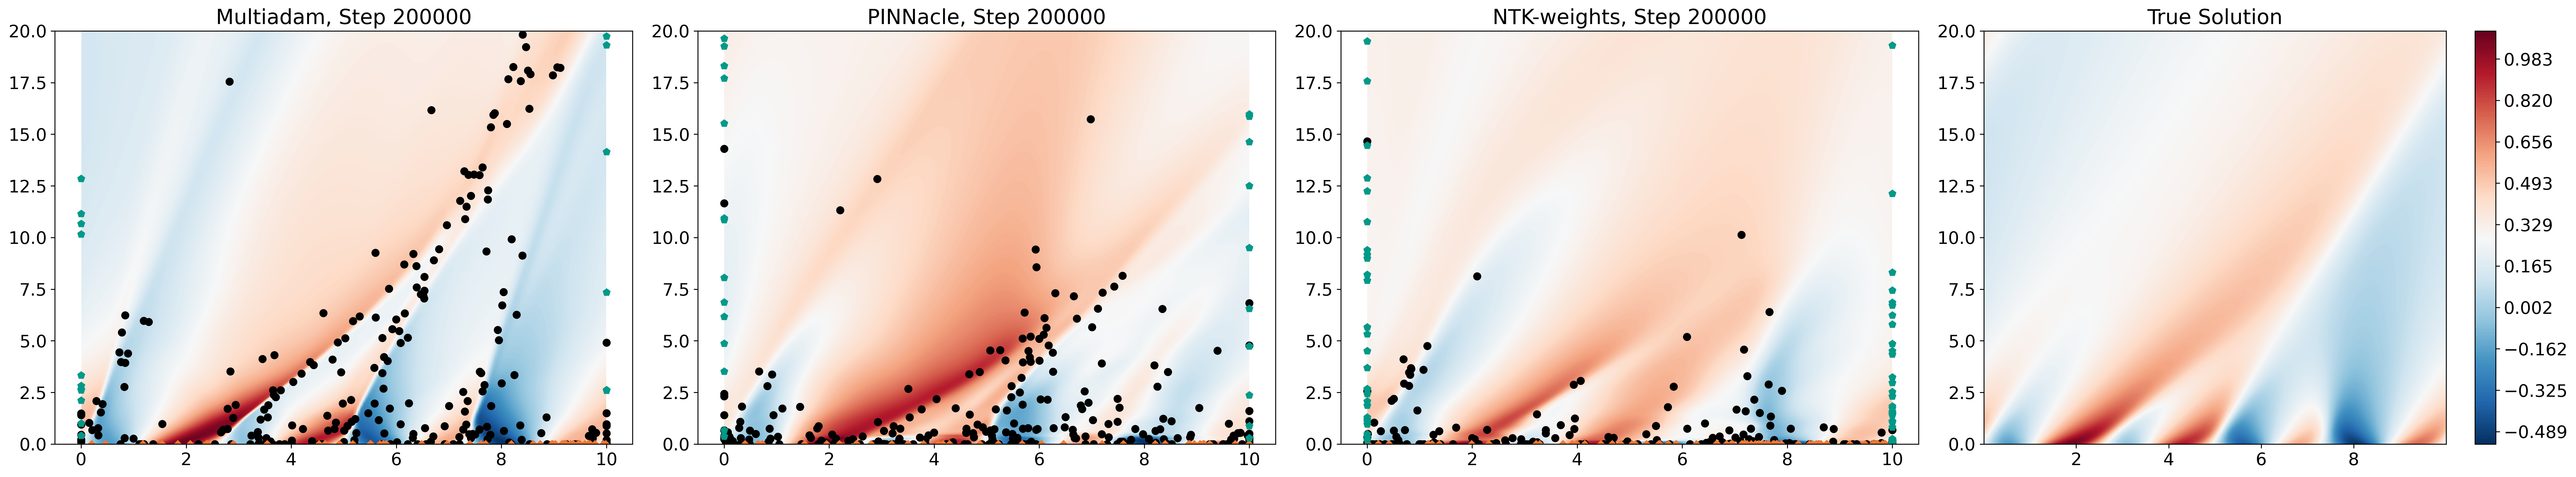

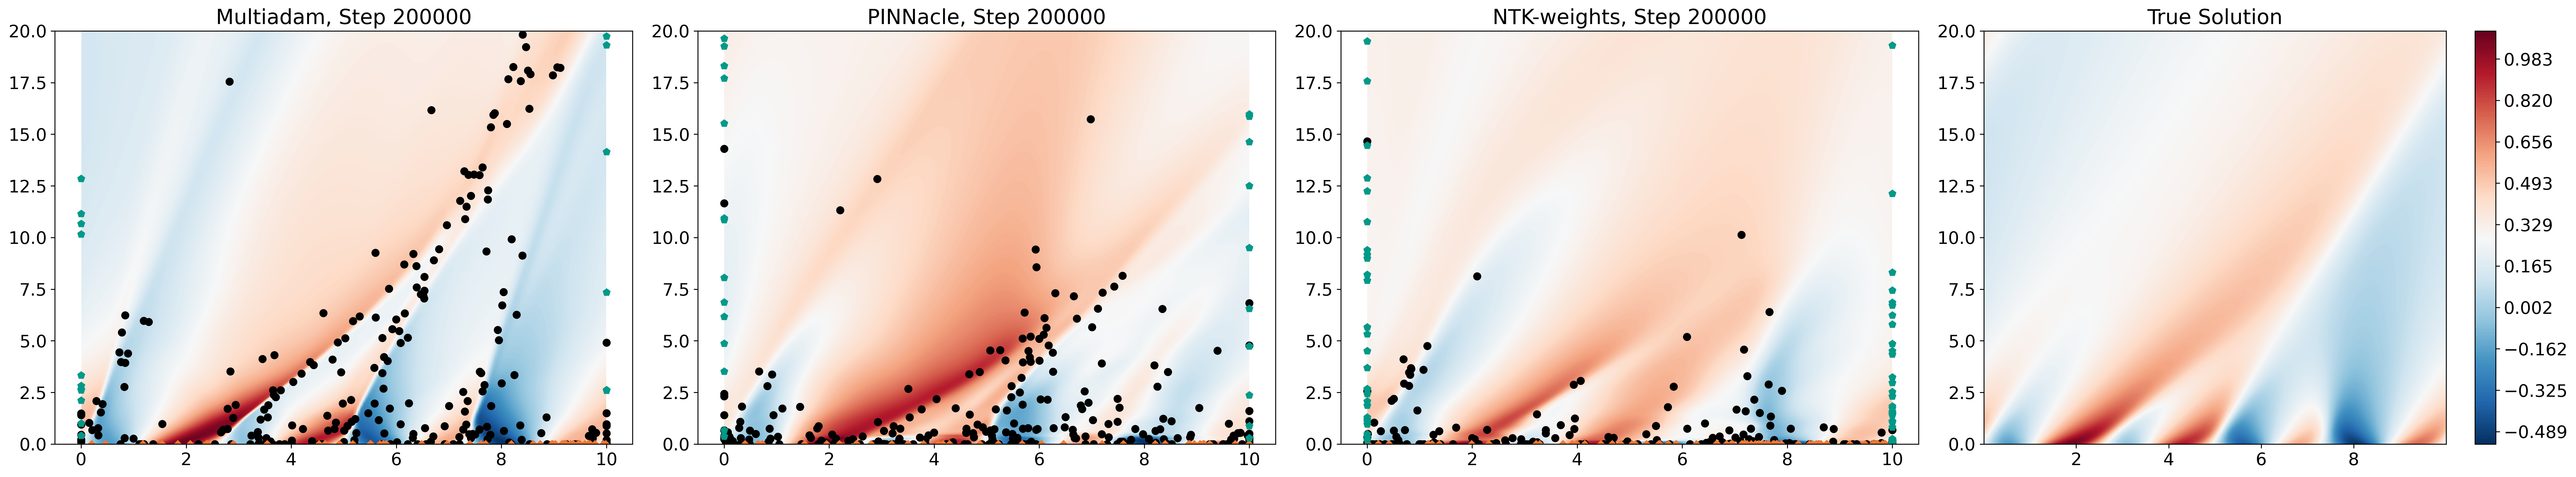

In [16]:
import copy

snapshot_dirs = [
    '/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_multiadam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106104424-57',
    '/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-1.0_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106125525-57',
    '/Users/moritzhauschulz/oxford_code/tdl/pinnacle_2024/pinnacle_code/al_pinn_results/burgers-1d{0.02}_pb-20_ic/nn-None-4-128_adam_bcsloss-auto_budget-300-100-0/sampling_alignment_scale-none_mem_autoal/20250106144104-26'
]
step = 200000

train_loops = []
for dir in snapshot_dirs:
    train_loop_copy = copy.deepcopy(train_loop)
    snapshot, al_data_round = load_snapshot(dir,step)
    train_loop_copy.snapshot_data, train_loop_copy.al_data_round = snapshot, al_data_round
    train_loops.append(train_loop_copy)

plot_multiple_predictions(train_loops, ['Multiadam', 'PINNacle', 'NTK-weights'], [step], res=200, plot_training_data=True, out_idx=0)